# Lensing Ray Tracing

This notebook demonstrates how to run a lensing lightcone in flowpm

In [1]:
%pylab inline 

import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power

Populating the interactive namespace from numpy and matplotlib


In [82]:
# Below are a few parameters
n_lens = 10       # Number of lensplanes in the lightcone
box_size=200.     # Transverse comoving size of the simulation volume
nc = 64           # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 64  # Number of pixels in the lensing field
batch_size = 4    # Number of simulations to run in parallel

In [3]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()

In [4]:
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])

# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)

In [10]:
# this should be the redshift of our last lens
1/a[-1] - 1

<tf.Tensor: shape=(), dtype=float32, numpy=0.82958937>

In [11]:
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [12]:
# Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, n_lens * nc],
                                         [box_size, box_size, n_lens * box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [13]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, n_lens * nc],return_intermediate_states=True) 

In [87]:
# Extract the lensplanes
lensplanes = []
for i in range(len(r_center)):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, n_lens * nc],
                                            r_center[i]/box_size*nc,
                                            width=nc,
                                            plane_resolution=nc)
    lensplanes.append((r_center[i], states[::-1][i][0], plane))

In [ ]:
# Here are the lens planes exported during the simulation
figure(figsize=(50,5))
for i in range(len(lensplanes)):
    subplot(1,10,i+1)
    imshow(lensplanes[i][-1][0])
    axis('off')

In [89]:
# Create a coordinate grid 
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [90]:
# Create array of source redshifts
z_source = tf.linspace(0.1, 0.83, 10)

In [91]:
m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/nc, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m = m.numpy().reshape([batch_size, field_npix, field_npix, 10])

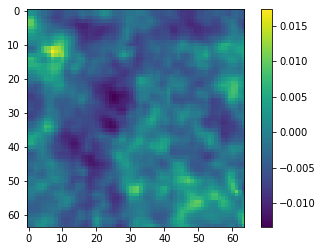

In [92]:
imshow(m[0,:,:,9]); colorbar();

## Bonus: comparing power spectrum to theory


In [101]:
import jax
import jax_cosmo as jc
import lenstools as lt
import astropy.units as u

In [102]:
nzs_s=jc.redshift.kde_nz(np.atleast_1d([0.83]), np.atleast_1d([1.]), bw=0.01)
probes = [ jc.probes.WeakLensing([nzs_s]) ]

In [103]:
l_edges = np.logspace(2,4, 16) 

In [104]:
ps = np.stack([lt.ConvergenceMap(kappa[...,-1], 5*u.deg).powerSpectrum(l_edges)[1] for kappa in m ], axis=0)
l, _ = lt.ConvergenceMap(m[0,:,:,-1], 5*u.deg).powerSpectrum(l_edges)

In [105]:
cls_th = jc.angular_cl.angular_cl(jc.Planck15(), l, probes)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


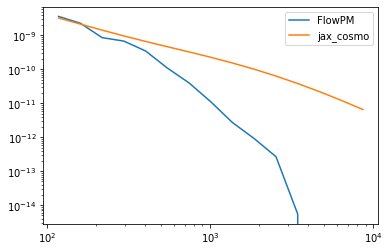

In [106]:
loglog(l, ps.mean(axis=0), label='FlowPM')
loglog(l, cls_th[0], label='jax_cosmo')
legend()